# Improving text generation with (larger) LSTM RNN

By Alex Gascón Bononad - alexgascon.93@gmail.com

## 0. Introduction

### 0.1. Introduction to the Notebook
The main objective of this notebook is to improve the work we ended with on the notebook #2 of this repository, in order to make more accurate predicitons



## 1. Description
If you remember properly, in the last notebook we ended up having a trained model that was able to generate text by predicting the next character of a 100 character string. And, although the text was almost perfect grammatically, it wasn't it so much syntactically or semantically, as the model repeated the same string over and over again.

Now, what we're going to do is to try different approaches and see the effects they have on the model, in order to improve those problems. 

## 2. Implementing improvements

### 2.1. Randomizing our prediction
The first approach we're going to try is to randomize our character prediction. However, with an important detail: the random distribution we'll use will be given by the output of our RNN.

Our RNN outputs an array of floating point numbers compressed between 0 and 1, each one representing the probability of the character in that position of being the most suitable option for the prediction. However, currently we search for the most suitable one and select it as our result. What we're going to try now, instead, is to randomize our prediction while taking into account this probabilities. 

We'll achieve this by using the output array of our RNN as the [Density Probability Function](https://es.wikipedia.org/wiki/Funci%C3%B3n_de_densidad_de_probabilidad) [1] for our randomized prediction. As this array contains the probability of each character, the sum of all its elements will always be 1 (because the probability of our prediction being a character, no matter which one, is 1). Let's see it with an example


We're going to load our last model and try to predict a random character, in order to see the output we get (the code is the same we've already used on previous notebooks, so don't worry about it)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

Using Theano backend.
Using gpu device 0: GeForce GTX 960M (CNMeM is disabled, cuDNN not available)


In [4]:
# Load the book and covert it to lowercase
filename = "El ingenioso hidalgo don Quijote de la Mancha (learning version).txt"
book = open(filename).read()
book = book.lower()

# Create mapping of unique chars to integers, and its reverse
chars = sorted(list(set(book)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
int_to_char = dict((i, c) for i, c in enumerate(chars))

# Summarizing the loaded data
n_chars = len(book)
n_vocab = len(chars)
print "Total Characters: ", n_chars
print "Total Vocab: ", n_vocab

# Prepare the dataset of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []

# Iterating over the book
for i in range(0, n_chars - seq_length, 1):
    sequence_in = book[i:i + seq_length]
    sequence_out = book[i + seq_length]
    
    # Converting each char to its corresponding int
    sequence_in_int = [char_to_int[char] for char in sequence_in]
    sequence_out_int = char_to_int[sequence_out]

    # Appending the result to the current data 
    dataX.append(sequence_in_int)
    dataY.append(sequence_out_int)
n_patterns = len(dataX)
print "Total Patterns: ", n_patterns

# Reshaping X to be [samples, time steps, features]
X = np.reshape(dataX, (n_patterns, seq_length, 1))
# Normalizing
X = X / float(n_vocab)
# One hot encode the output variable
y = np_utils.to_categorical(dataY)

# Define the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1], activation='softmax'))

# Load the network weights
filename = "weights-improvement-03-1.4625.hdf5"
model.load_weights(filename)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Pick a random seed
start = np.random.randint(0, len(dataX)-1)
pattern = dataX[start]
seed = ''.join([int_to_char[value] for value in pattern])
print "Seed:"
print "\"", seed, "\""
result_str = ""

Total Characters:  169841
Total Vocab:  53
Total Patterns:  169741
Seed:
" en advertida de lo que había de responder, le dijo:

-¿qué aposento, o qué nada, busca vuestra m "


Now, we'll use our model to generate a single prediction: we're not even going to learn a character for it, we simply want to check the output array

In [5]:
# Generate characters
x = np.reshape(pattern, (1, len(pattern), 1))
x = x / float(n_vocab)
prediction = model.predict(x, verbose=0)

In [8]:
print(prediction)

[[  9.32860331e-08   6.03365288e-06   2.39249455e-20   1.71725629e-37
    9.86871685e-37   5.24590093e-41   6.46692873e-22   2.52526746e-07
    4.47217879e-14   2.45524223e-08   3.95824087e-14   6.05850873e-12
    1.60745153e-10   3.88618112e-02   9.67724759e-07   3.66645423e-07
    1.19763985e-08   9.07419145e-01   4.21649077e-07   4.44439621e-07
    7.69924036e-09   9.97275673e-03   1.32874218e-08   4.90474704e-05
    4.88973410e-06   1.14809307e-04   2.43147891e-02   2.45739614e-07
    4.04799833e-10   8.91197182e-04   1.59814925e-04   6.82486098e-06
    1.04477759e-02   5.19759169e-07   2.14637756e-13   1.22084441e-06
    2.07428366e-06   5.11083757e-18   4.53893275e-18   6.82661122e-14
    9.85387993e-10   7.61603454e-12   1.31578578e-17   8.42543202e-10
    3.34366215e-13   1.10627493e-10   6.25858698e-10   2.04194449e-13
    3.23132249e-15   4.92435260e-18   9.55458042e-23   7.74442824e-03]]
52


As we can see, the array contains numbers between 0 and 1; each one represents the probability of the character in that position of being the correct character to output. However, this doesn't seem to be a very clear representation. Let's see it graphically.

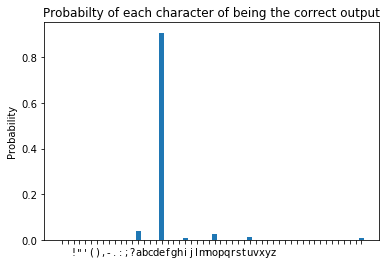

In [27]:
# Creating the indices array
indices = np.arange(len(prediction[0]))

# Creating the plots
fig, ax = plt.subplots()
preds = ax.bar(indices, prediction[0])

# Adding some text for labels and titles
ax.set_ylabel('Probability')
ax.set_title('Probabilty of each character of being the correct output')
ax.set_xticks(indices)
ax.set_xticklabels((c for c in chars if ord(c) < 0x81))  # We can't use non ascii chars as label
plt.show()

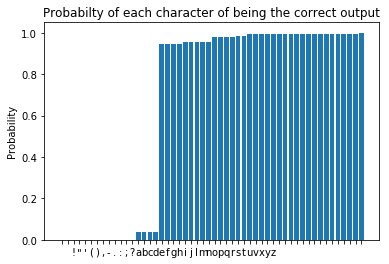

In [31]:
prob_cum = np.cumsum(prediction[0])

# Creating the indices array
indices = np.arange(len(prob_cum))

# Creating the plots
fig, ax = plt.subplots()
preds = ax.bar(indices, prob_cum)

# Adding some text for labels and titles
ax.set_ylabel('Probability')
ax.set_title('Probabilty of each character of being the correct output')
ax.set_xticks(indices)
ax.set_xticklabels((c for c in chars if ord(c) < 0x81))  # We can't use non ascii chars as label
plt.show()